In [174]:
import pandas 
from sklearn import gaussian_process, preprocessing, manifold, pipeline, model_selection
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 

### Collect the data

First, we have to collect all the data together. 

In [175]:
df = pandas.read_csv('/Users/alex/Documents/bagel-benchmark/rosetta_runs/benchmark/feature_set.csv', index_col=0)
df.head()

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
description,,,,,,,,,,,,,,,,,,,,,
A192S,-666.807,290.370,-70.057,0.0,0.695,0.691,151.4,439.4,151.4,0.916,...,0.869,446.0,-4.639,1.074,-3.332,0.011,-9.275,0.905,7.2,1.0
A227W,6540.056,7501.653,-70.331,0.0,0.699,0.697,153.7,438.6,152.2,0.944,...,0.728,446.0,-4.658,1.084,-3.404,0.033,-9.314,0.902,7.4,1.0
A236E,756.791,1691.476,-70.300,0.0,0.692,0.689,153.2,438.1,151.6,0.927,...,0.832,446.0,-4.474,1.094,-3.155,0.028,-8.945,0.903,7.0,1.0
A249E,-509.443,419.493,-69.785,0.0,0.690,0.690,159.1,434.2,149.3,0.848,...,0.888,446.0,-4.534,1.039,-3.216,0.021,-9.069,0.900,7.0,1.0
A356A,-691.757,286.213,-70.166,0.0,0.699,0.700,151.1,438.0,151.1,0.825,...,0.892,446.0,-4.740,1.064,-3.408,0.009,-9.483,0.904,7.2,1.0


In [176]:
tgts = 'kcat km kcatkm'.split()
t = pandas.read_csv('../data_set/bglb_data_set.csv', index_col='mutant_name')[tgts]
t.head()

,kcat,km,kcatkm
mutant_name,,,
S14A,320.0,8.25,38823.0
T15A,614.0,5.30,115849.0
S16A,154.0,14.01,10997.0
S17A,848.0,18.45,45978.0
S17E,641.0,7.32,87596.0


/Users/alex/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


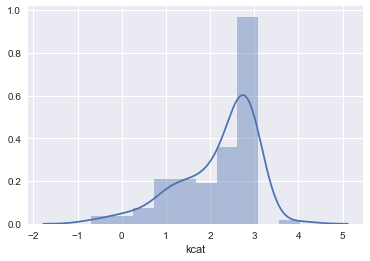

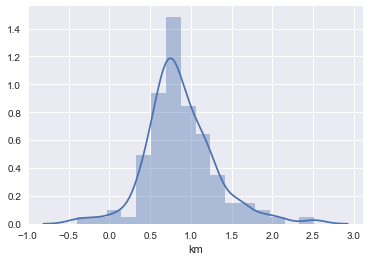

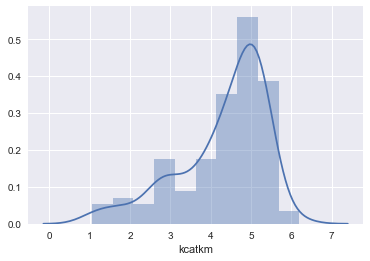

In [177]:
for col in t:
    x = np.log10(t[col])
    #x = (x - x.mean())/x.std()**2
    sns.distplot(x)
#     t['{}n'.format(col)] = x 
    plt.show()

In [178]:
df = df.join(t).dropna()
df.shape

features = df.drop(tgts,axis=1)
target = df[tgts] 

features.shape, target.shape

((104, 59), (104, 3))

Overall, we have 104 samples, each with a kcat, KM, and kcat/KM, as well as 59 Rosetta features derived from Rosetta enzyme design simulation. We are interested in the Rosetta enzyme design ability to discriminate between active and inactive enzymes. We can define an active enzyme as an enzyme that has

- kcat > 1 turnover per min 
- KM < 50 mM 

and label our data accordingly if we wish 

In [179]:
target_active = []
for idx, (kcat, km, kcatkm) in target.iterrows():
    condition = kcat > 1 and km < 50
    if condition:
        target_active.append(1)
    else:
        target_active.append(0) 


### Begin machine learning problem 

OK, we have a feature set and a target. 59 seems like a big number of features for this small of a data set, so let's see if we can remove some uninformative features. 

In [180]:
drop_me = []
for col in features:
    if features[col].std() == 0.0:
        # is constant 
        drop_me.append(col)
        
drop_me

['all_cst',
 'tot_seq_recovery',
 'SR_1',
 'SR_2',
 'SR_3',
 'SR_4',
 'SR_4_all_cst',
 'SR_5']

In [181]:
X = features.drop(drop_me, axis=1) 
X.shape 

(104, 51)

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


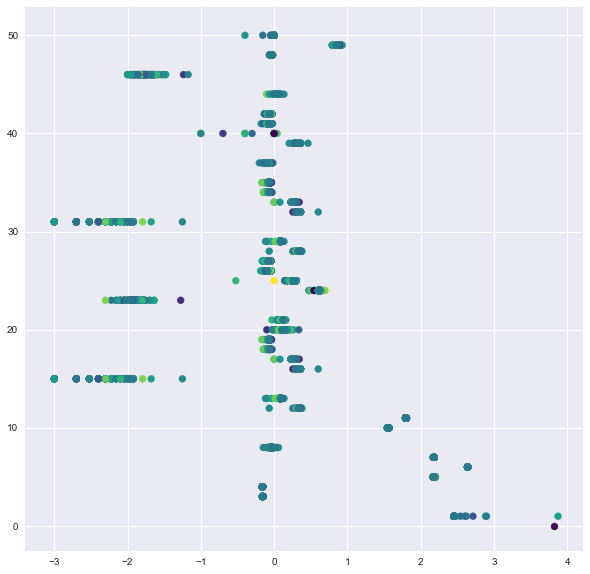

In [182]:
plt.figure(figsize=(10,10))
for n, col in enumerate(X):
    xform = np.log10(X[col])
    plt.scatter(xform,[n]*len(X[col]),c=np.log10(target['km']), cmap='viridis')

In [183]:
scaler = preprocessing.StandardScaler()
X_scaled = pandas.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.shape

(104, 51)

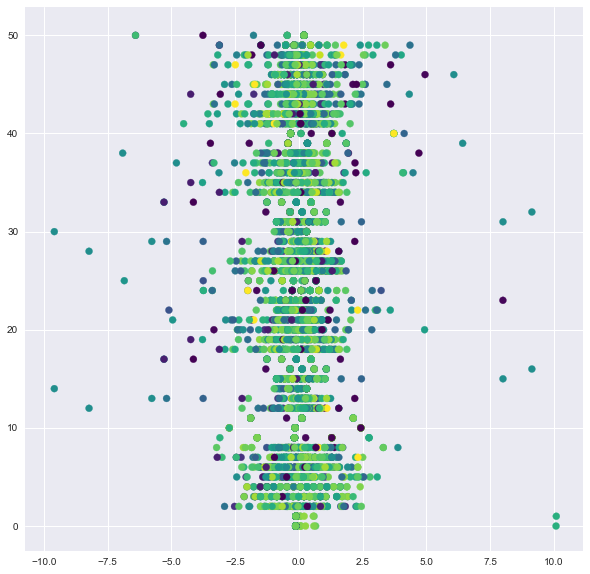

In [184]:
plt.figure(figsize=(10,10))
for n, col in enumerate(X):
    xform = X_scaled[col]
    #xform = ( xform - xform.mean() ) / xform.std()**2
    plt.scatter(xform,[n]*len(X[col]),c=np.log10(target['kcatkm']), cmap='viridis')

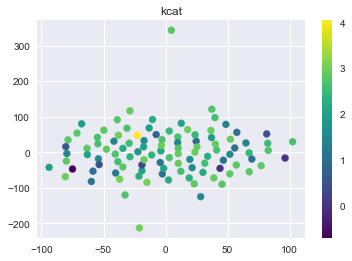

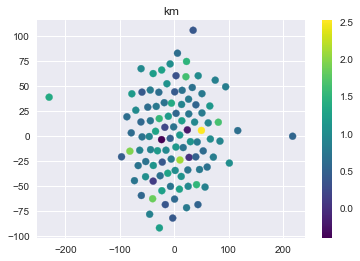

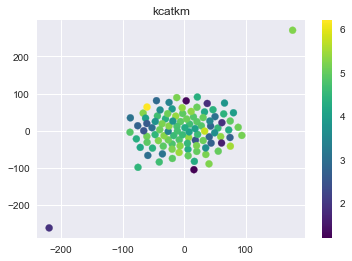

In [185]:
for kk in tgts:
    tsne = manifold.TSNE(perplexity=70)
    X_ = tsne.fit_transform(X_scaled)
    plt.scatter(X_[:,0], X_[:,1], c=np.log10(target[kk]), cmap='viridis')
    plt.colorbar()
    plt.title(kk)
    plt.show()

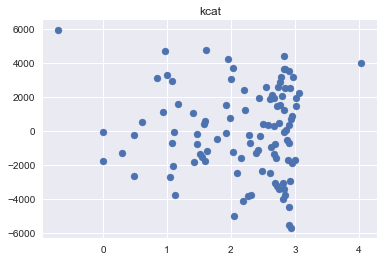

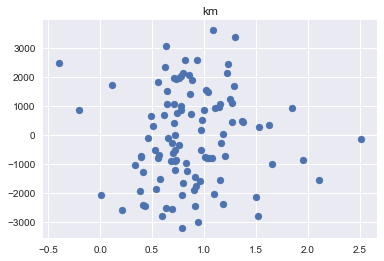

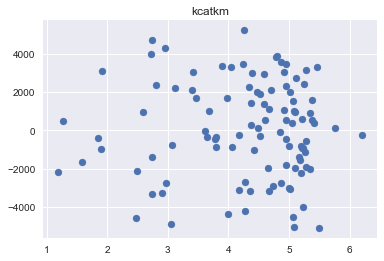

In [186]:
# 1-d t-SNE 

for kk in tgts:
    tsne = manifold.TSNE(n_components=1)
    X_ = tsne.fit_transform(X_scaled)
    plt.scatter(np.log10(target[kk]), X_)
    plt.title(kk)
    plt.show()

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


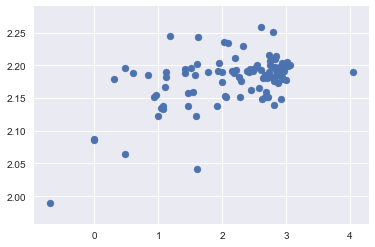

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


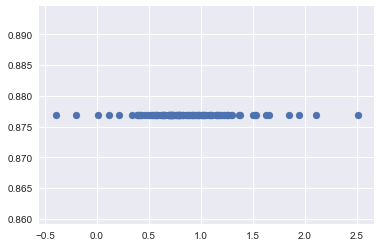

/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


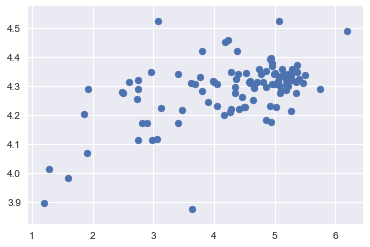

In [193]:
from sklearn import linear_model 

for tgt in tgts:
    y = np.log10(target[tgt])
    clf = linear_model.ElasticNetCV(l1_ratio=[0.1,0.5,0.9,0.99], cv=10, normalize=True, max_iter=1e4)
    clf.fit(X_scaled, y)
    preds = clf.predict(X_scaled) 
    plt.scatter(y, preds) 
    plt.show()

In [187]:
from sklearn import decomposition

In [188]:
pln = pipeline.Pipeline([
    ('scl', preprocessing.StandardScaler()), 
#     ('tsne', manifold.TSNE()), 
    ('pca', decomposition.PCA(n_components=3)),  
    ('clf', gaussian_process.GaussianProcessRegressor(n_restarts_optimizer=10)),
])

preds = model_selection.cross_val_predict(pln, X_scaled, np.log10(target['km']), cv=10)

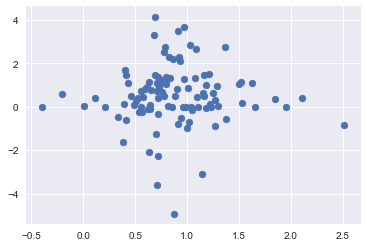

In [168]:
plt.scatter(np.log10(target['km']), preds)